In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import json
import scipy

In [85]:
def scatter_x_vs_y(x, y, xmax, ymax, xlabel, ylabel, title=" "):
    fig = plt.figure(figsize=(6, 6))
    fig.patch.set_facecolor("white")
    plt.axis((0.0, xmax, 0.0, ymax))
    plt.plot([0, xmax], [0, ymax], color="red")
    plt.scatter(x, y, s=0.01)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Load config and scores df

In [86]:
config_file = "cori_config.json"
with open(config_file, "r") as f:
    p = json.load(f)

In [87]:
df_scores_ordered = pd.read_pickle("SCORES.pkl.gz")

In [88]:
max_tm_scores = np.maximum(df_scores_ordered["TM1"], df_scores_ordered["TM2"])
df_scores_ordered["distance"]     = 1 - max_tm_scores
df_scores_ordered["TM_aln_q_cov"] = df_scores_ordered['Lali']/df_scores_ordered['qlen']

In [89]:
df_scores_ordered["weight"] = (100 / df_scores_ordered["pidentity"]) ** 3

In [90]:
# Find the maximum TMscore for each row, then get the corresponding TM %id. 
df_dummy = df_scores_ordered[['TM1', 'TM2']].rename(columns={"TM1":0, "TM2":1})
df_maxcol = df_dummy.idxmax(axis='columns').values
vals = df_scores_ordered[['pID1', 'pID2']].values
max_TM_pid = vals[np.arange(len(vals)), df_maxcol] 
df_scores_ordered['max_TM_pid'] = 100 * max_TM_pid

In [91]:
# Calculate the TMalign IDali to blast %id ratio
df_scores_ordered['pid_concordance'] = 100 * df_scores_ordered['IDali']/df_scores_ordered['pidentity']
df_scores_ordered['hsp_q_cov_concordance'] = 100 * df_scores_ordered['TM_aln_q_cov']/df_scores_ordered['perc_q_cov_per_hsp']

In [208]:
df_scores_ordered['perc_q_cov_per_hsp'].max()

100

In [93]:
df_scores_ordered.sample(5).head()[['TM1', 'TM2', 'pID1', 'pID2', 'pidentity', 'weight', 'distance']]

TM1     TM2   pID1   pID2  pidentity     weight  distance
1130693  0.9608  0.9608  0.919  0.919     91.919   1.287609    0.0392
2090623  0.9898  0.9898  0.964  0.964     96.484   1.113356    0.0102
3150156  0.8779  0.8970  0.521  0.533     53.704   6.456246    0.1030
3034587  0.7262  0.7236  0.631  0.628     83.962   1.689475    0.2738
3141550  0.5242  0.5103  0.233  0.226     36.842  19.997256    0.4758

## Filter out sequences longer than cutoff. Also keep only ordered pairs.

In [94]:
MAX_LEN = p['MAX_SEQ_LEN']
TMSCORE_CUTOFF = 0.0 #p['TMSCORE_CUTOFF']
df_scores = df_scores_ordered[
    (df_scores_ordered.qlen <= MAX_LEN) & 
    (df_scores_ordered.tlen <= MAX_LEN) & 
    (df_scores_ordered.TM1 > TMSCORE_CUTOFF) & 
    (df_scores_ordered.TM2 > TMSCORE_CUTOFF)]

In [95]:
print("# pairs w/ 0 RMSD: ",len(df_scores[df_scores.RMSD == 0]))
print("Max RMSD for the length-filtered set", df_scores.RMSD.max())

# pairs w/ 0 RMSD:  74
Max RMSD for the length-filtered set 8.41


# Stats

In [96]:
all_ids = np.append(df_scores.qid.unique(), df_scores.tid.unique())
all_ids = np.unique(all_ids)

df_train = df_scores[df_scores.train_or_holdout == 0]
df_singleHO = df_scores[(df_scores.train_or_holdout == 1) | (df_scores.train_or_holdout == 2)]
df_doubleHO = df_scores[df_scores.train_or_holdout == 3]

print("{:,} pairs in complete df_scores (training+holdout, no filtering)".format(len(df_scores_ordered)))
print("{:,} pairs after length filtering (training+holdout; cutoff = {} residues)".format(len(df_scores), MAX_LEN))
print("{:,} PDB IDs after length filtering (training+holdout)".format(len(all_ids)))
print("{:,} pairs in training set".format(len(df_train)))
print("{:,} pairs in single holdout".format(len(df_singleHO)))
print("{:,} pairs in double holdout".format(len(df_doubleHO)))

3,218,568 pairs in complete df_scores (training+holdout, no filtering)
3,017,730 pairs after length filtering (training+holdout; cutoff = 400 residues)
64,617 PDB IDs after length filtering (training+holdout)
2,288,424 pairs in training set
663,592 pairs in single holdout
65,714 pairs in double holdout


# Visualization

## Plot distributions

In [97]:
def plot_hist(df_column, title, ylabel, xlabel, savefile, bins=100):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.patch.set_facecolor('white')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    df_column.hist(bins=bins, ax=ax)
    plt.savefig(savefile)
    plt.show()

In [98]:
folder = "save/plots/"
prefix = "COMPLETE_DATA_SET_"

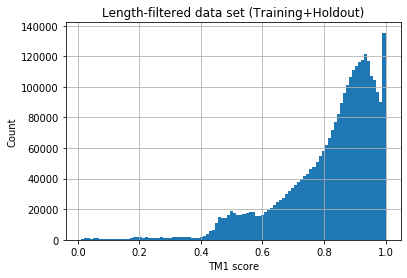

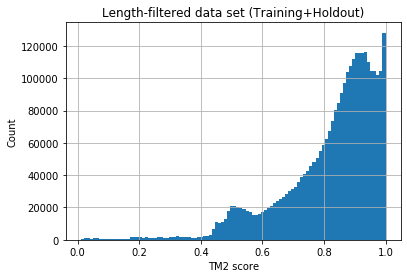

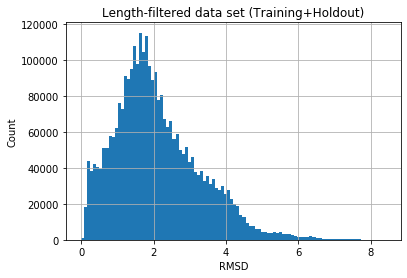

In [99]:
plot_hist(
    df_scores.TM1, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'TM1 score',
    folder + prefix + "TM1-score.png"
)

plot_hist(
    df_scores.TM2, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'TM2 score',
    folder + prefix + "TM1-score.png"
)

plot_hist(
    df_scores.RMSD, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'RMSD',
    folder + prefix + "RMSD.png"
)

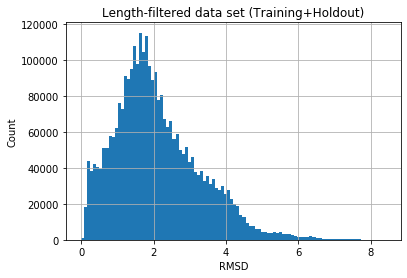

In [100]:
plot_hist(
    df_scores.RMSD, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'RMSD',
    folder + prefix + "RMSD.png"
)

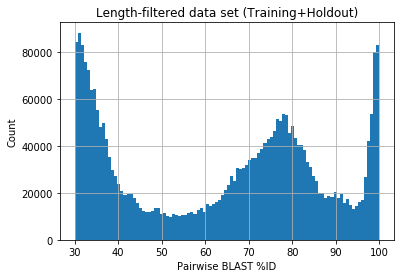

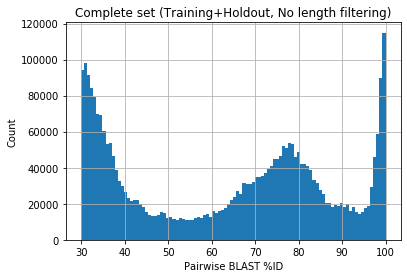

In [101]:
plot_hist(
    df_scores.pidentity, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'Pairwise BLAST %ID',
    folder + prefix + "blast_pID.png"
)

plot_hist(
    df_scores_ordered.pidentity, 
    'Complete set (Training+Holdout, No length filtering)',
    'Count',
    'Pairwise BLAST %ID',
    folder + prefix + "blast_pID.png"
)

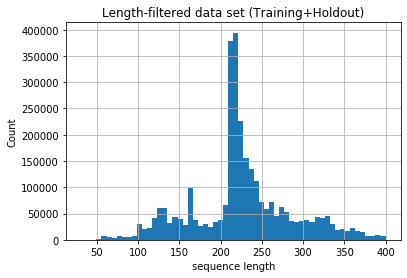

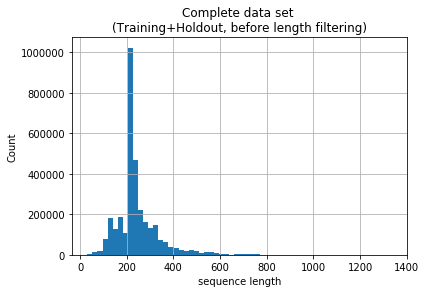

In [102]:
plot_hist(
    df_scores.qlen, 
    'Length-filtered data set (Training+Holdout)',
    'Count',
    'sequence length',
    folder + prefix + "sequence_length.png",
    bins=60
)

plot_hist(
    df_scores_ordered.qlen, 
    'Complete data set \n(Training+Holdout, before length filtering)',
    'Count',
    'sequence length',
    folder + prefix + "sequence_length.png",
    bins=60
)

## Plot joint distributions: %sequence id vs structural similarity score

In [103]:
#df_sample = df_scores.sample(n=1000000)
df_sample = df_scores
x = df_sample.pidentity.values
y = 1 - df_sample['distance']

double_HO_set = df_sample[df_sample.train_or_holdout==3]
x_holdout = double_HO_set.pidentity.values
y_holdout = double_HO_set.TM1.values

<Figure size 216x216 with 0 Axes>

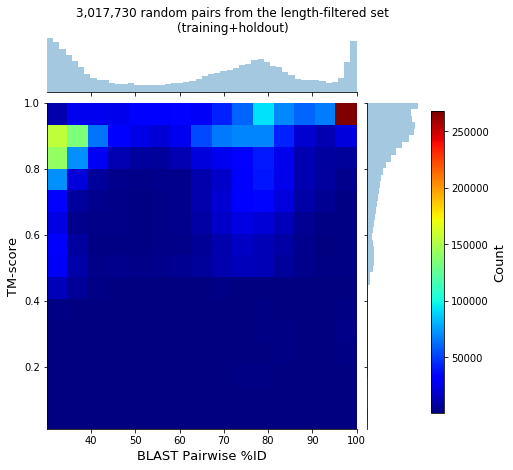

In [104]:
title = "{:,} random pairs from the length-filtered set\n(training+holdout)".format(len(df_sample))
xlabel = "BLAST Pairwise %ID"
ylabel = "TM-score"
savefile = folder + prefix + "tmscore_vs_pidentity.png"

fig = plt.figure(figsize=(3,3))
fig.patch.set_facecolor('white')


ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
plt.savefig(savefile)

<Figure size 216x216 with 0 Axes>

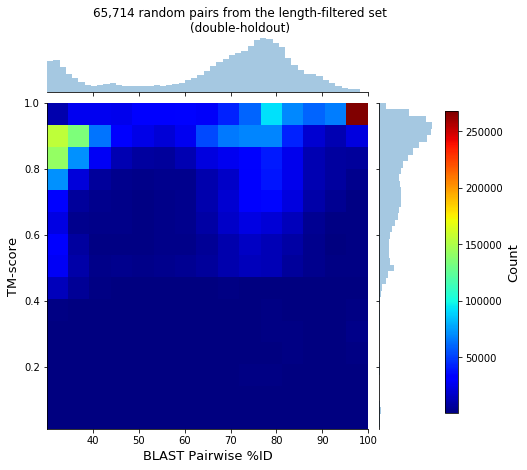

In [105]:
title = "{:,} random pairs from the length-filtered set\n(double-holdout)".format(len(x_holdout))

fig = plt.figure(figsize=(3,3))
fig.patch.set_facecolor('white')
savefile = folder + prefix + "tmscore_vs_pidentity_2.png"

ax1 = sns.jointplot(x=x_holdout, y=y_holdout)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

#h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet, range=[(30,95),(0,.95)]);
h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
plt.savefig(savefile)

## Max %ID between a seq in the holdout set and and on in the training set

Why is this important? Because I want to find out if any of my holdout seq sequences are very similar to the trianing ones. That would defeat the purpose of a holdout set.

In [106]:
# Select training_or_holdout == 1, which is the set of pairs with the first sequence is from the holdout PDBids.
double_HO_set = df_scores[df_scores.train_or_holdout==3]

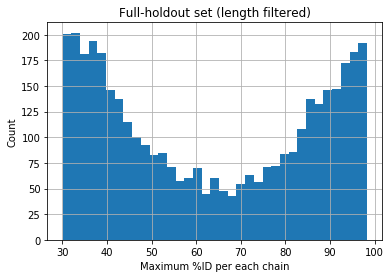

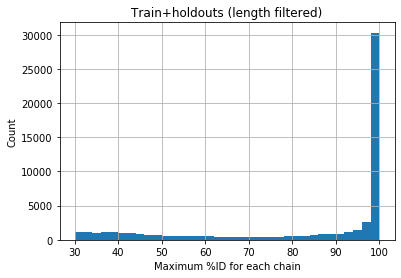

In [107]:
df_doubleHO_max_pid = double_HO_set[['qid', 'pidentity']].groupby('qid').max()
df_scores_max_pid   = df_scores[['qid', 'pidentity']].groupby('qid').max()

plot_hist(
    df_doubleHO_max_pid.pidentity,
    'Full-holdout set (length filtered)',
    'Count',
    'Maximum %ID per each chain',
    folder + prefix + "doubleHO_max_pid_to_training_set.png",
    bins=35
)


plot_hist(
    df_scores_max_pid.pidentity,
    'Train+holdouts (length filtered)',
    'Count',
    'Maximum %ID for each chain',
    folder + prefix + "doubleHO_max_pid_to_training_set.png",
    bins=35
)

In [108]:
"{:.2f}".format(12.11123)

'12.11'

# %sequence identity vs tmscore

In [109]:
df_scores.head(2)

pdbid1  model1 chain1 pdbid2  model2 chain2     TM1     TM2  RMSD   pID1  \
0   101m       1      A   102m       1      A  0.9989  0.9989  0.15  0.987   
1   101m       1      A   104m       1      A  0.9826  0.9890  0.50  0.981   

   ...  perc_q_cov_per_hsp         evalue  bitscore  train_or_holdout  \
0  ...                 100  7.080000e-108     304.0                 0   
1  ...                  99  3.630000e-107     302.0                 0   

   distance TM_aln_q_cov    weight  max_TM_pid  pid_concordance  \
0    0.0011     1.000000  1.040005        98.7         0.999990   
1    0.0110     0.993506  1.040258        98.7         1.000071   

  hsp_q_cov_concordance  
0              1.000000  
1              1.003542  

[2 rows x 36 columns]

In [110]:
df_scores.columns

Index(['pdbid1', 'model1', 'chain1', 'pdbid2', 'model2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'L1', 'L2', 'Lali', 'qseq',
       'tseq', 'qlen_tm', 'tlen_tm', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp', 'evalue',
       'bitscore', 'train_or_holdout', 'distance', 'TM_aln_q_cov', 'weight',
       'max_TM_pid', 'pid_concordance', 'hsp_q_cov_concordance'],
      dtype='object')

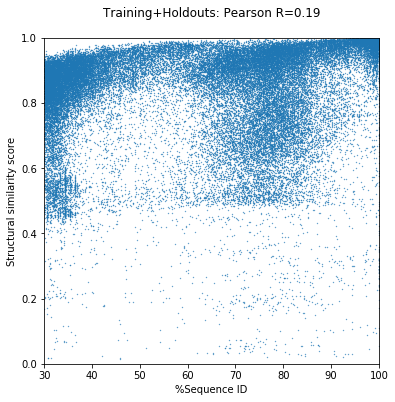

In [111]:
import scipy

df_sample = df_scores.sample(50000)
pidentity = df_sample['pidentity']
tm_score = 1 - df_sample['distance']

R, p = scipy.stats.pearsonr(pidentity, tm_score)
title = "Training+Holdouts: Pearson R={:.2f}\n".format(R)

fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor("white")
plt.axis((30, 100, 0., 1))
plt.scatter(pidentity, tm_score, s=0.1)
#plt.plot([0, 1], [0, 1], color="red")
plt.title(title)
plt.xlabel("%Sequence ID")
plt.ylabel("Structural similarity score")
#file_name = SAVE_PLOTS_DIR + "-TEST-SINGLEHO-actual_vs_predicted.png"
#plt.savefig(file_name, format="png", pad_inches=0.3)
plt.show()

# TMscore vs RMSD

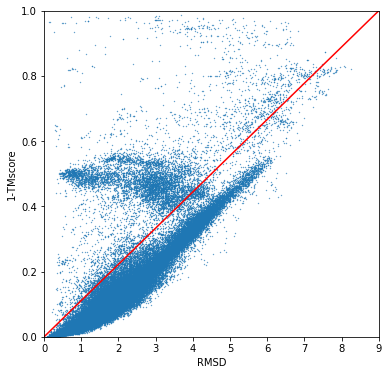

In [112]:
df_sampled = df_scores.sample(100000)
y = df_sampled.distance.values
x = df_sampled.RMSD.values

fig = plt.figure(figsize=(6, 6))
fig.patch.set_facecolor("white")
plt.axis((0.0, 9, 0.0, 1))
plt.plot([0, 9], [0, 1], color="red")
plt.scatter(x, y, s=0.1)
#plt.title(title)
plt.xlabel("RMSD")
plt.ylabel("1-TMscore")
plt.show()

<Figure size 216x216 with 0 Axes>

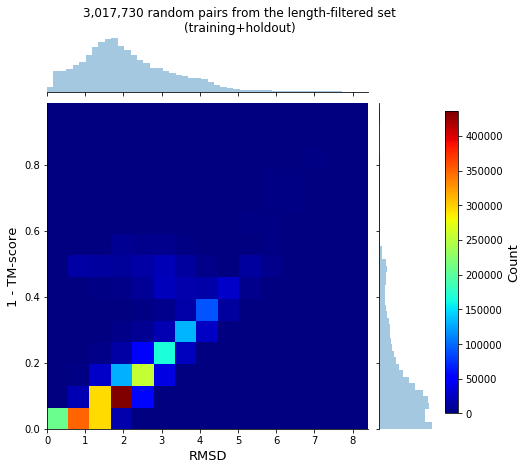

In [113]:
df_sampled = df_scores
y = df_sampled.distance.values
x = df_sampled.RMSD.values

title = "{:,} random pairs from the length-filtered set\n(training+holdout)".format(len(df_sampled))
xlabel = "RMSD"
ylabel = "1 - TM-score"
savefile = folder + prefix + "tmscore_vs_RMSD.png"

fig = plt.figure(figsize=(3,3))
fig.patch.set_facecolor('white')

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

h = plt.hist2d(x, y, bins=(15, 15), cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
plt.savefig(savefile)

# Inspect above-diagonal pairs

In [114]:
df_selected = df_scores[df_scores.RMSD !=0].copy()
df_selected['d_rmsd_ratio'] = [ 9*d/rmsd for d, rmsd in df_selected[['distance', 'RMSD']].values ]

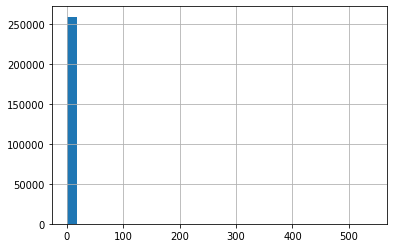

In [115]:
df_selected[df_selected['d_rmsd_ratio']>1]['d_rmsd_ratio'].hist(bins=30)

In [116]:
df_offdiagonals = df_selected[df_selected['d_rmsd_ratio']>1.0]
print("Offdiagonals count:", len(df_offdiagonals))
df_offdiagonals[['qid', 'tid', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'L1', 'L2', 'Lali', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp', 'distance', 'd_rmsd_ratio']].sample(20).sort_values(by='pidentity')

Offdiagonals count: 259454


qid       tid     TM1     TM2  RMSD   pID1   pID2  IDali   L1  \
218538   1d5x_B    6vpy_B  0.4936  0.4406  4.10  0.142  0.125  0.222  183   
2940450  5m3v_B    6db6_L  0.5459  0.4551  3.13  0.194  0.160  0.304  175   
354725   1g1q_A    4zes_A  0.6576  0.7108  2.08  0.219  0.238  0.297  160   
967997   1yzk_A    2yc2_C  0.6028  0.6708  2.55  0.196  0.221  0.280  168   
435369   1i3r_B    5gkr_B  0.4423  0.4479  3.61  0.134  0.136  0.250  216   
1824308  3mwi_U    6nvb_A  0.2431  0.2596  6.64  0.065  0.072  0.143  246   
3034999  5vom_A    6bqd_A  0.7260  0.7114  1.99  0.214  0.209  0.250  126   
361134   1g86_A    6k2y_A  0.7551  0.7707  2.02  0.433  0.442  0.526  141   
2144243  4c3z_A    6bzs_A  0.3423  0.3434  5.69  0.325  0.326  0.591  231   
3087078  6al0_L  6ss5_LLL  0.5007  0.4942  2.95  0.286  0.282  0.504  213   
2619686  6k4z_A    4uim_A  0.4996  0.5061  1.14  0.326  0.330  0.632  227   
2847845  5fyj_U    6o3k_L  0.7590  0.4465  2.12  0.227  0.126  0.255  119   
2550992  5ogi_B    4q2z_H  0.4810  0.4997  1.30  0.361  0.375  0.718  233   
3073048  5y2k_A    6obd_B  0.5334  0.5618  2.91  0.439  0.464  0.726  223   
2239154  4g3y_H  6ss5_HHH  0.5731  0.5565  3.29  0.409  0.396  0.616  220   
2801371  5dt1_L    6bp2_L  0.5229  0.5229  2.99  0.414  0.414  0.690  215   
648146   1n8z_B    5itb_H  0.5674  0.5674  3.51  0.459  0.459  0.673  220   
791752   1rzf_L    6ii9_L  0.5332  0.5356  2.64  0.441  0.443  0.746  213   
2081504  3wg8_A    5k53_A  0.3054  0.2616  5.13  0.034  0.028  0.067  175   
2992479  5to2_A    6lng_A  0.1229  0.1219  0.38  0.124  0.123  1.000  121   

          L2  Lali  pidentity  aln_len  mismatches  qlen  tlen  \
218538   208   117     30.909      110          70   192   213   
2940450  213   112     30.935      139          92   227   214   
354725   147   118     32.479      117          72   162   147   
967997   149   118     32.749      171         106   184   208   
435369   213   116     32.955       88          55   228   216   
1824308  223   112     33.198      247         131   246   224   
3034999  129   108     33.333       84          54   149   130   
361134   138   116     50.000      138          69   142   142   
2144243  230   127     59.471      227          92   266   238   
3087078  216   121     60.465      215          79   214   220   
2619686  224   117     61.475      122          43   247   225   
2847845  214   106     62.617      107          33   240   215   
2550992  224   117     68.548      124          32   254   233   
3073048  211   135     78.448      232          32   233   216   
2239154  227   146     79.825      228          42   226   233   
2801371  215   129     83.028      218          35   217   217   
648146   220   150     85.135      222          22   220   220   
791752   212   126     88.152      211          24   213   212   
2081504  217    89     88.235       34           3   227   262   
2992479  122    15     97.600      125           3   125   125   

         perc_q_cov_per_hsp  distance  d_rmsd_ratio  
218538                   54    0.5064      1.111610  
2940450                  59    0.4541      1.305719  
354725                   71    0.2892      1.251346  
967997                   88    0.3292      1.161882  
435369                   37    0.5521      1.376427  
1824308                  98    0.7404      1.003554  
3034999                  56    0.2740      1.239196  
361134                   97    0.2293      1.021634  
2144243                  85    0.6566      1.038559  
3087078                  99    0.4993      1.523288  
2619686                  48    0.4939      3.899211  
2847845                  42    0.2410      1.023113  
2550992                  46    0.5003      3.463615  
3073048                  99    0.4382      1.355258  
2239154                 100    0.4269      1.167812  
2801371                 100    0.4771      1.436087  
648146                   98    0.4326      1.109231  
791752                   99    0.46

In [117]:
df_sampled = df_offdiagonals.sample(50000)

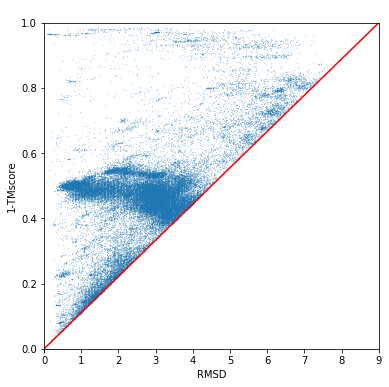

In [118]:
x = df_sampled.RMSD.values
y = df_sampled.distance.values
scatter_x_vs_y(x,y,9,1,"RMSD","1-TMscore")

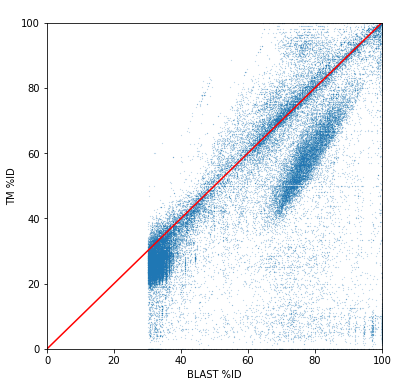

In [119]:
x = df_sampled.pidentity.values
y = 100*df_sampled.IDali.values
scatter_x_vs_y(x,y,100,100,"BLAST %ID","TM %ID")

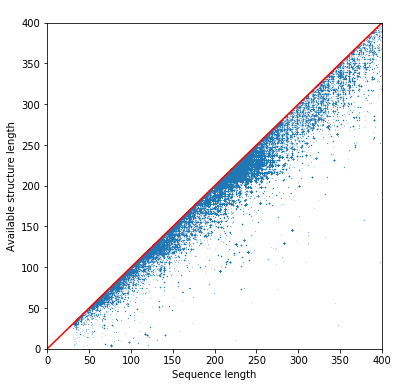

In [120]:
x = df_offdiagonals.qlen_tm.values
y = df_offdiagonals.L1.values
scatter_x_vs_y(x,y,400,400,"Sequence length","Available structure length")

In [121]:
df_offdiagonals.columns

Index(['pdbid1', 'model1', 'chain1', 'pdbid2', 'model2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'L1', 'L2', 'Lali', 'qseq',
       'tseq', 'qlen_tm', 'tlen_tm', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp', 'evalue',
       'bitscore', 'train_or_holdout', 'distance', 'TM_aln_q_cov', 'weight',
       'max_TM_pid', 'pid_concordance', 'hsp_q_cov_concordance',
       'd_rmsd_ratio'],
      dtype='object')

In [122]:
seqid=0.3
structid=.50

(structid/seqid)**3

4.629629629629631

# Find the number of connected components in the TM-score network 

In [123]:
import networkx as nx

In [124]:
def get_connected_comps(df):
    edge_list = df[['qid', 'tid', 'distance']].values.tolist()
    edge_list_for_nx = [[q, t, {'w': d}] for q, t, d in edge_list]        
    G = nx.Graph(edge_list_for_nx)
    cc = sorted(nx.connected_components(G), key=len, reverse=True)
    return cc, edge_list

## Look into all examples

In [125]:
cc, edge_list = get_connected_comps(df_scores)

In [126]:
print("#connected components:", len(cc))
print("Largest component size:", len(cc[0]))

#connected components: 6046
Largest component size: 20673


In [127]:
n_pairs_in_cc_list = [len(x) for x in cc]
cc_index = range(1, len(n_pairs_in_cc_list)+1)

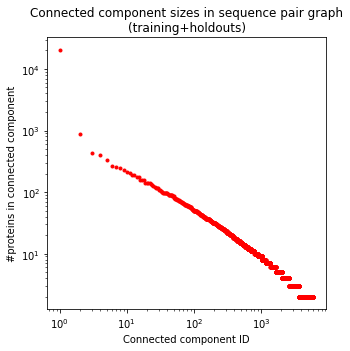

In [128]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')

plt.plot(cc_index, n_pairs_in_cc_list,  "r.")
plt.xscale('log')
plt.yscale('log')
#plt.axis((.5, 50000, .5, 2000))
plt.xlabel("Connected component ID")
plt.ylabel("#proteins in connected component")
plt.title("Connected component sizes in sequence pair graph\n(training+holdouts)")
plt.show()

In [129]:
df_largest_cc = df_scores[df_scores.qid.isin(cc[0])]

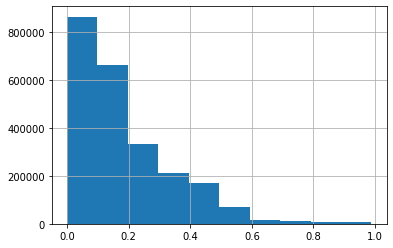

In [130]:
fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('white')
df_largest_cc.distance.hist(ax=ax)

## Now filter out all distances < 0.5, and count the CCs

In [131]:
df_scores_pruned = df_scores[df_scores.distance<0.5]
cc, edge_list = get_connected_comps(df_scores_pruned)

In [132]:
print("#connected components:", len(cc))
print("Largest component size:", len(cc[0]))

#connected components: 6335
Largest component size: 6051


In [133]:
n_pairs_in_cc_list = [len(x) for x in cc]
cc_index = range(1, len(n_pairs_in_cc_list)+1)

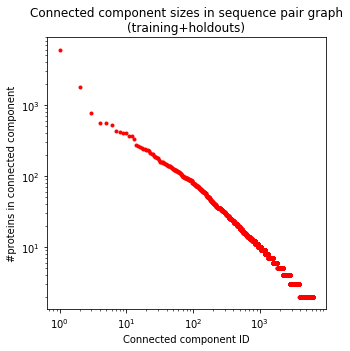

In [134]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')
plt.plot(cc_index, n_pairs_in_cc_list,  "r.")
plt.xscale('log')
plt.yscale('log')
#plt.axis((.5, 50000, .5, 2000))
plt.xlabel("Connected component ID")
plt.ylabel("#proteins in connected component")
plt.title("Connected component sizes in sequence pair graph\n(training+holdouts)")
plt.show()

In [135]:
df_largest_cc = df_scores[df_scores.qid.isin(cc[0])]

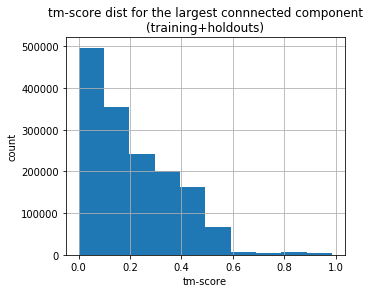

In [136]:
fig, ax = plt.subplots(figsize=(5,4))
fig.patch.set_facecolor('white')
df_largest_cc.distance.hist(ax=ax)
plt.xlabel("tm-score")
plt.ylabel("count")
plt.title("tm-score dist for the largest connnected component\n(training+holdouts)")
plt.show()

## Look into the largest connected component in the unpruned graph

### How many CCs does the largest one split into if you remove links w/ d<0.5?

In [137]:
df_largest_cc_pruned = df_largest_cc[df_largest_cc.distance<0.5]

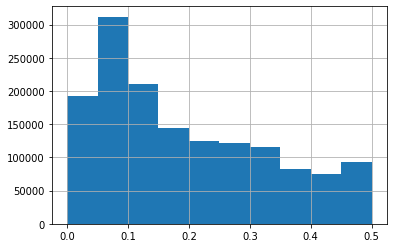

In [138]:
df_largest_cc_pruned.distance.hist()

In [139]:
cc_2, edge_list_2 = get_connected_comps(df_largest_cc_pruned)

In [140]:
len(cc_2)

1

In [141]:
n_pairs_in_cc_list = [len(x) for x in cc_2]
cc_index = range(1, len(n_pairs_in_cc_list)+1)

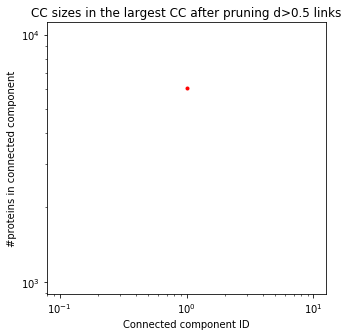

In [142]:
fig, ax = plt.subplots(figsize=(5,5))
fig.patch.set_facecolor('white')
plt.plot(cc_index, n_pairs_in_cc_list,  "r.")
plt.xscale('log')
plt.yscale('log')
#plt.axis((.5, 50000, .5, 2000))
plt.xlabel("Connected component ID")
plt.ylabel("#proteins in connected component")
plt.title("CC sizes in the largest CC after pruning d>0.5 links")
plt.show()

In [143]:
len(cc_2[0])

6051

In [144]:
cc_index

range(1, 2)

# Does supplementing blast alignment to TMalign yield a considerable improvement in TMscores?

## Find rows with TM %id == 0. Since all blast %id >0, these rows yield blast_pid/tm_pid = inf

In [145]:
df_zero_TM_pid = df_scores[df_scores['max_TM_pid']<=0]

In [146]:
df_zero_TM_pid[['pdbid1', 'chain1', 'pdbid2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp',
       'bitscore']].sort_values(by='pidentity', ascending=False).head(20)

pdbid1 chain1 pdbid2 chain2     TM1     TM2  RMSD  pID1  pID2  IDali  \
3163619   6hbd      A   6hyh      A  0.0445  0.0446  5.33   0.0   0.0    0.0   
2475486   4nnu      A   4qpj      A  0.2629  0.2484  4.80   0.0   0.0    0.0   
2816618   5eid      A   5jzv      A  0.3779  0.2922  4.08   0.0   0.0    0.0   
2639696   4whv      A   6kfp      D  0.1163  0.1131  3.11   0.0   0.0    0.0   
1773744   3l7y      A   5u4z      A  0.2206  0.2879  6.32   0.0   0.0    0.0   
2931991   5lb7      A   5myd      A  0.2714  0.2790  4.60   0.0   0.0    0.0   
1739822   3jvz      X   6kfp      D  0.1131  0.1152  3.70   0.0   0.0    0.0   
2793774   5dk8      A   5j8p      B  0.0325  0.1288  1.50   0.0   0.0    0.0   
474917    1izl      E   1s5l      E  0.4652  0.3010  1.96   0.0   0.0    0.0   
2767746   5csj      C   5csn      C  0.3053  0.3340  2.00   0.0   0.0    0.0   
1462024   2yje      M   3tpm      B  0.0808  0.1722  1.05   0.0   0.0    0.0   
2767745   5csi      C   5csn      C  0.1717  0.1356  0.59   0.0   0.0    0.0   
2435676   4m03      A   4ofe      A  0.2099  0.2320  4.94   0.0   0.0    0.0   
3039023   6njd      A   5vyc     f1  0.1558  0.2588  3.69   0.0   0.0    0.0   
1313416   2q33      B   3mon      B  0.2696  0.0566  0.56   0.0   0.0    0.0   
1313415   2q33      A   4mon      A  0.6541  0.0454  0.07   0.0   0.0    0.0   
2458781   4n4g      A   4umi      A  0.2019  0.3060  4.83   0.0   0.0    0.0   
1221486   2iw5      B   3zez      A  0.2288  0.1935  4.58   0.0   0.0    0.0   
3081868   5zqi      A   6p5q      A  0.1919  0.1729  6.13   0.0   0.0    0.0   
1147645   2g0i      A   6ey2      A  0.2697  0.2815  3.79   0.0   0.0    0.0   

            qid      tid  pidentity  aln_len  mismatches  qlen  tlen  \
3163619  6hbd_A   6hyh_A      100.0      319           0   320   319   
2475486  4nnu_A   4qpj_A      100.0       36           0   230   243   
2816618  5eid_A   5jzv_A      100.0       34           0   168   206   
2639696  4whv_A   6kfp_D      100.0       76           0    83    77   
1773744  3l7y_A   5u4z_A      100.0       34           0   304   265   
2931991  5lb7_A   5myd_A      100.0       34           0   212   207   
1739822  3jvz_X   6kfp_D      100.0       76           0    81    77   
2793774  5dk8_A   5j8p_B      100.0       74           0    76    76   
474917   1izl_E   1s5l_E      100.0       83           0    83    84   
2767746  5csj_C   5csn_C      100.0       25           0    42    40   
1462024  2yje_M   3tpm_B      100.0      120           0   137   120   
2767745  5csi_C   5csn_C      100.0       32           0    49    40   
2435676  4m03_A   4ofe_A      100.0       34           0   210   192   
3039023  6njd_A  5vyc_f1      100.0       76           0   157   156   
1313416  2q33_B   3mon_B      100.0       48           0    48    50   
1313415  2q33_A   4mon_A      100.0       43           0    43    45   
2458781  4n4g_A   4umi_A      100.0       33           0   252   208   
1221486  2iw5_B   3zez_A      100.0       34           0   235   204   
3081868  5zqi_A   6p5q_A      100.0       36           0   277   308   
1147645  2g0i_A   6ey2_A      100.0       24           0   145   146   

         perc_q_cov_per_hsp  bitscore  
3163619                  99     650.0  
2475486                  16      56.2  
2816618                  20      52.0  
2639696                  92     153.0  
1773744                  11      53.1  
2931991                  16      54.3  
1739822                  94     154.0  
2793774                  97     149.0  
474917                  100     171.0  
2767746                  60      52.0  
1462024                  88     233.0  
2767745                  65      65.9  
2435676                  16      51.2  
3039023                  48     157.0  
1313416                 100     101.0  
1313415                 100      89.4  
2458781                  13      50.1  
1221486                  14      51.6  
3081868                  13      64.3  
1147645       

In [147]:
%%bash
fgrep -A1 1bi4_A nr_pdb_filtered.faa > pdb/1bi4_A.faa
fgrep -A1 6nuj_A nr_pdb_filtered.faa > pdb/6nuj_A.faa

In [148]:
df_scores[['pdbid1', 'chain1', 'pdbid2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp',
       'bitscore']].sort_values(by='pidentity', ascending=False).head(20)

pdbid1 chain1 pdbid2 chain2     TM1     TM2  RMSD   pID1   pID2  \
1615916   3epz      A   5ydr      B  0.7434  0.6765  3.67  0.686  0.612   
750229    1qkm      A   1u3r      A  0.9039  0.9001  1.60  0.904  0.900   
750083    1qjc      A   6cck      A  0.9706  0.9586  0.95  1.000  0.987   
1945472   3r4m      A   6ei5      A  0.9275  0.9532  1.43  0.972  1.000   
1945466   3r4m      A   5j82      A  0.9336  0.9642  1.22  0.967  1.000   
750107    1qk0      A   3cbh      A  0.9979  0.9925  0.32  1.000  0.995   
750228    1qkm      A   1u3q      A  0.9027  0.9183  1.55  0.878  0.894   
1945462   3r4m      A   5j2x      A  0.9328  0.9589  1.47  0.967  0.995   
1945461   3r4m      A   5j20      A  0.9350  0.9656  1.22  0.963  0.995   
1945456   3r4m      A   4ykq      A  0.9239  0.9541  1.56  0.967  1.000   
750079    1qjc      A   5jbn      A  0.9906  0.9722  0.50  1.000  0.981   
1945452   3r4m      A   4nh7      A  0.9263  0.9611  1.29  0.963  1.000   
1945451   3r4m      A   4lwe      A  0.9291  0.9594  1.31  0.967  1.000   
1945449   3r4m      A   4egh      A  0.9313  0.9572  1.49  0.972  1.000   
1945448   3r4m      A   4eeh      A  0.9239  0.9586  1.47  0.963  1.000   
1945447   3r4m      A   4b7p      A  0.9907  0.9953  0.38  0.995  1.000   
1945446   3r4m      A   4awo      A  0.9233  0.9675  1.26  0.949  0.995   
1945445   3r4m      A   3tuh      A  0.9435  0.9699  1.07  0.972  1.000   
750082    1qjc      A   6b7a      A  0.9744  0.9623  0.92  1.000  0.987   
750046    1qj4      A   1yb6      A  0.9998  0.9998  0.09  1.000  1.000   

         IDali     qid     tid  pidentity  aln_len  mismatches  qlen  tlen  \
1615916  0.699  3epz_A  5ydr_B      100.0      249           0   268   250   
750229   0.959  1qkm_A  1u3r_A      100.0      241           0   255   241   
750083   1.000  1qjc_A  6cck_A      100.0      158           0   158   161   
1945472  1.000  3r4m_A  6ei5_A      100.0      209           0   228   209   
1945466  1.000  3r4m_A  5j82_A      100.0      225           0   228   225   
750107   1.000  1qk0_A  3cbh_A      100.0      363           0   363   365   
750228   0.935  1qkm_A  1u3q_A      100.0      240           0   255   240   
1945462  0.995  3r4m_A  5j2x_A      100.0      208           0   228   209   
1945461  0.995  3r4m_A  5j20_A      100.0      207           0   228   208   
1945456  1.000  3r4m_A  4ykq_A      100.0      228           0   228   238   
750079   1.000  1qjc_A  5jbn_A      100.0      158           0   158   170   
1945452  1.000  3r4m_A  4nh7_A      100.0      228           0   228   233   
1945451  1.000  3r4m_A  4lwe_A      100.0      208           0   228   208   
1945449  1.000  3r4m_A  4egh_A      100.0      228           0   228   232   
1945448  1.000  3r4m_A  4eeh_A      100.0      228           0   228   229   
1945447  1.000  3r4m_A  4b7p_A      100.0      228           0   228   230   
1945446  1.000  3r4m_A  4awo_A      100.0      228           0   228   230   
1945445  1.000  3r4m_A  3tuh_A      100.0      209           0   228   209   
750082   1.000  1qjc_A  6b7a_A      100.0      158           0   158   167   
750046   1.000  1qj4_A  1yb6_A      100.0      256           0   257   256   

         perc_q_cov_per_hsp  bitscore  
1615916                  93     516.0  
750229                   95     489.0  
750083                  100     327.0  
1945472                  92     429.0  
1945466                  99     461.0  
750107                  100     743.0  
750228                   94     487.0  
1945462                  91     427.0  
1945461                  91     425.0  
1945456                 100     467.0  
750079                  100     325.0  
1945452                 100     466.0  
1945451                  91     427.0  
1945449                 100     466.0  
1945448                 100     466.0  
1945447                 100     466.0  
1945446                 100     467.0  
1945445                  92     429.0  
750082                  100     3

## Look for inconsistent blast vs tmalign %id pairs

### ...find high blast %id, lower TM IDali 

In [149]:
inconsistent_filter = (df_scores['IDali']<=.90) &\
                      (df_scores['IDali']>.0) &\
                      (df_scores['pidentity']==100) &\
                      (df_scores['Lali']/df_scores['aln_len']<0.9) &\
                      (df_scores['perc_q_cov_per_hsp']>=99) 
            
#                     (df_scores['chain1']=='A') &\
#                     (df_scores['chain2']=='A') &\
df_inconsistent = df_scores[inconsistent_filter]

In [150]:
len(df_inconsistent)

332

In [151]:
percent = 100 * len(df_inconsistent)/len(df_scores)
print(f"{percent:.2f}%")

0.01%


In [152]:
df_inconsistent[['qid','tid', 'pID1', 'pID2', 'RMSD', 'max_TM_pid', 'IDali', "Lali", 'pidentity', 'aln_len',
                 'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp']].sort_values(by='max_TM_pid', ascending=False).head(5)

qid     tid   pID1   pID2  RMSD  max_TM_pid  IDali  Lali  \
1841815  3nkd_A  5ds4_A  0.855  0.875  2.97        87.5  0.892   251   
1282752  2oug_A  5ond_A  0.837  0.874  0.93        87.4  0.881   134   
798464   1s3o_A  2dud_A  0.776  0.874  1.19        87.4  0.874    95   
1090968  2dud_A  6rup_A  0.874  0.748  0.92        87.4  0.874    95   
1354941  2rd0_B  4l1b_B  0.871  0.437  1.82        87.1  0.871   139   

         pidentity  aln_len  mismatches  qlen  tlen  perc_q_cov_per_hsp  
1841815      100.0      305           0   305   306                 100  
1282752      100.0      161           0   162   162                  99  
798464       100.0      132           0   132   133                 100  
1090968      100.0      133           0   133   142                 100  
1354941      100.0      279           0   279   324                 100

In [153]:
http = "https://files.rcsb.org/download/"
index = 1282752
rec = df_inconsistent.loc[index]
qid = rec['qid']
tid = rec['tid']
qseq = rec['qseq']
tseq = rec['tseq']

q_pdbid = rec['pdbid1']
t_pdbid = rec['pdbid2']
q_chain = rec['chain1']
t_chain = rec['chain2']

print(q_pdbid, t_pdbid)

! wget {http}{q_pdbid}.cif -q -N -P ./pdb 
! wget {http}{t_pdbid}.cif -q -N -P ./pdb
! wget {http}{q_pdbid}.pdb -q -N -P ./pdb
! wget {http}{t_pdbid}.pdb -q -N -P ./pdb

print(f">{qid}\n{qseq}\n")
print(f">{tid}\n{tseq}\n")

2oug 5ond
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
wget: /global/software/sl-7.x86_64/modules/langs/python/3.7/lib/libuuid.so.1: no version information available (required by wget)
>2oug_A
MQSWYLLYCKRGQLQRAQEHLERQAVNCLAPMITLEKIVRGKRTAVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGASPAIVPSAVIHQLSVYKPKDIVDPATPYPGDKVIITEGAFEGFQAIFTEPDGEARSMLLLNLINKEIKHSVKNTEFRKL

>5ond_A
MQSWYLLYCKRGQLQRAQEHLERQAVNCLAPMITLEKIVRGKRTAVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGASPAIVPSAVIHQLSVYKPKDIVDPATPYPGDKVIITEGAFEGFQAIFTEPDGEARSMLLLNLINKEIKHSVKNTEFRKA



In [154]:
! cd pdb; ../TMalign {q_pdbid}.cif {t_pdbid}.cif -S1 {q_chain} -S2 {t_chain} -split 2 -ter 0 -outfmt 2

#PDBchain1	PDBchain2	TM1	TM2	RMSD	ID1	ID2	IDali	L1	L2	Lali
2oug.cif:1:A	5ond.cif:1:A	0.9222	0.9621	0.93	0.837	0.874	0.881	141	135	134
Total CPU time is  0.05 seconds


In [155]:
! cd pdb; ../TMalign {q_pdbid}.pdb {t_pdbid}.pdb -S1 {q_chain} -S2 {t_chain} -split 2 -ter 0 -outfmt 2

#PDBchain1	PDBchain2	TM1	TM2	RMSD	ID1	ID2	IDali	L1	L2	Lali
2oug.pdb:1:A	5ond.pdb:1:A	0.9222	0.9621	0.93	0.837	0.874	0.881	141	135	134
Total CPU time is  0.04 seconds


In [156]:
! cd pdb; ../TMalign {q_pdbid}.cif {t_pdbid}.cif -split 2 -ter 0 -outfmt 2

#PDBchain1	PDBchain2	TM1	TM2	RMSD	ID1	ID2	IDali	L1	L2	Lali
Total CPU time is  0.01 seconds


In [157]:
len(qseq)

162

### Plot TM query coverage (Lali/qlen)

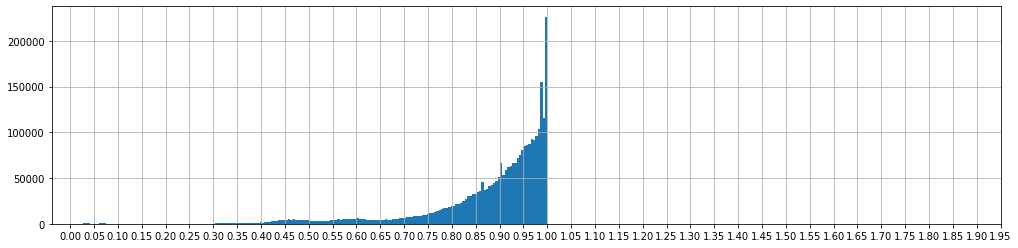

In [158]:
ticks = np.arange(0, 2, 0.05)
fig, ax = plt.subplots(figsize=(17,4))
fig.patch.set_facecolor('white')
df_scores['TM_aln_q_cov'].hist(bins=200) 
ax.set_xticks(ticks) 
plt.show()

### %query_cov_per_hsp concordance

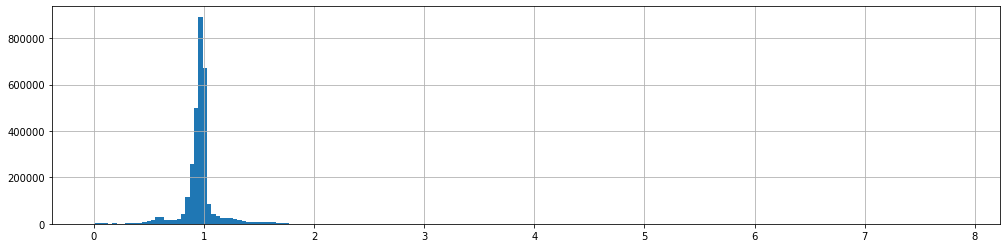

In [163]:
#ticks = np.arange(0, 2, 0.05)
fig, ax = plt.subplots(figsize=(17,4))
fig.patch.set_facecolor('white')
df_scores['hsp_q_cov_concordance'].hist(bins=200) 
#ax.set_xticks(ticks) 
plt.show()

### check %id concordance (tm/blast %id ratio)

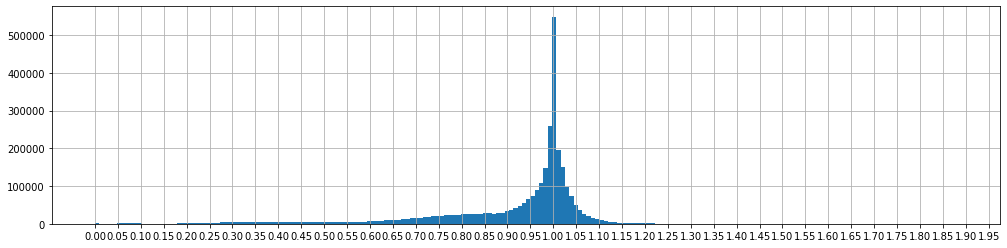

In [159]:
ticks = np.arange(0, 2, 0.05)
fig, ax = plt.subplots(figsize=(17,4))
fig.patch.set_facecolor('white')
df_scores['pid_concordance'].hist(bins=200) 
ax.set_xticks(ticks) 
plt.show()

### Count pairs w/ pid_concordance > cutoff

In [218]:
pid_concordance_cutoff = .9
q_cov_concordance_cutoff = .9
q_cov_cutoff = 90
select_above_pid_concordance_cutoff       = (df_scores['pid_concordance'] >= pid_concordance_cutoff)
select_above_hsp_q_cov_concordance_cutoff = (df_scores['hsp_q_cov_concordance'] >= q_cov_concordance_cutoff)
select_above_hsp_q_cov_cutoff             = (df_scores['perc_q_cov_per_hsp'] >= q_cov_cutoff)


num_all_pairs = len(df_scores)
df_dummy = df_scores[select_above_pid_concordance_cutoff & \
                     select_above_hsp_q_cov_concordance_cutoff & \
                     select_above_hsp_q_cov_cutoff]

num_above_cutoff = len(df_dummy)
frac_above_cutoff = num_above_cutoff/num_all_pairs
print("{:.2f}, {:,}".format(frac_above_cutoff, num_above_cutoff))

0.54, 1,619,362


In [219]:
df_dummy.columns

Index(['pdbid1', 'model1', 'chain1', 'pdbid2', 'model2', 'chain2', 'TM1',
       'TM2', 'RMSD', 'pID1', 'pID2', 'IDali', 'L1', 'L2', 'Lali', 'qseq',
       'tseq', 'qlen_tm', 'tlen_tm', 'qid', 'tid', 'pidentity', 'aln_len',
       'mismatches', 'qlen', 'tlen', 'perc_q_cov_per_hsp', 'evalue',
       'bitscore', 'train_or_holdout', 'distance', 'TM_aln_q_cov', 'weight',
       'max_TM_pid', 'pid_concordance', 'hsp_q_cov_concordance'],
      dtype='object')

In [220]:
df_dummy = df_dummy.sort_values(by='hsp_q_cov_concordance', ascending=True)
df_dummy[['qid', 'tid', "qlen", "tlen", "L1", "L2", "Lali", "aln_len", 'IDali', 'pidentity', 'pid_concordance', 'hsp_q_cov_concordance', 'perc_q_cov_per_hsp']].head(5)

qid     tid  qlen  tlen   L1   L2  Lali  aln_len  IDali  \
3101856  6b5l_L  6phg_B   220   218  218  203   198      220  0.838   
544470   1kxq_E  4m3j_A   120   126  120  116   108      126  0.676   
810008   1sib_I  4b1t_B    70    70   63   69    63       70  0.968   
810010   1sib_I  4b2b_B    70    71   63   71    63       70  0.968   
1864048  3od6_X  5o90_A   360   360  344  330   324      360  0.975   

         pidentity  pid_concordance  hsp_q_cov_concordance  perc_q_cov_per_hsp  
3101856     84.091         0.996539                    0.9                 100  
544470      62.698         1.078184                    0.9                 100  
810008      97.143         0.996469                    0.9                 100  
810010      97.143         0.996469                    0.9                 100  
1864048     98.889         0.985954                    0.9                 100

### Plot concordance distribution for above concordance and hsp query coverage cutoffs

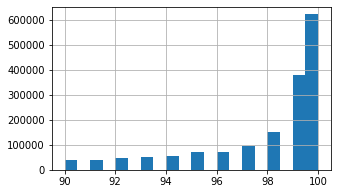

In [221]:
fig, ax = plt.subplots(figsize=(5,3))
fig.patch.set_facecolor('white')
df_dummy['perc_q_cov_per_hsp'].hist(bins=20) 

### Plot perc_q_cov_per_hsp distribution for all

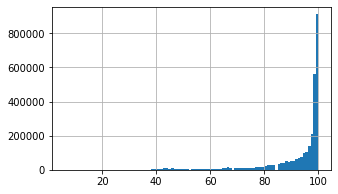

In [222]:
fig, ax = plt.subplots(figsize=(5,3))
fig.patch.set_facecolor('white')
df_scores['perc_q_cov_per_hsp'].hist(bins=100) 

### Concordance for high hsp query cov and high concordance

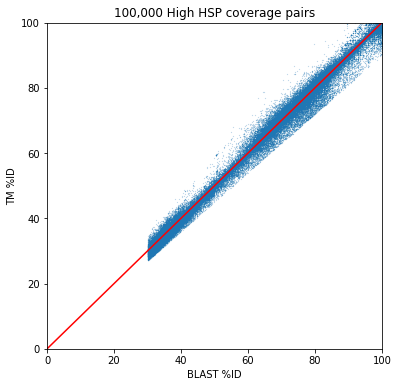

In [224]:
df_high_coverage = df_dummy.sample(100000)
x = df_high_coverage.pidentity.values
y = 100*df_high_coverage.IDali.values
title = "{:,} High HSP coverage pairs".format(len(df_high_coverage))
scatter_x_vs_y(x,y,100,100,"BLAST %ID","TM %ID", title)

### Concordance for only high hsp query coverage

<Figure size 216x216 with 0 Axes>

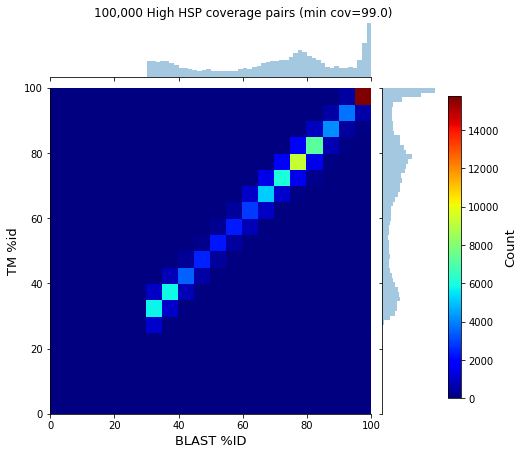

In [225]:
x = df_high_coverage.pidentity.values
y = 100*df_high_coverage.IDali.values

title = "{:,} High HSP coverage pairs (min cov={:.1f})".format(len(df_high_coverage), high_cov_threshold)
xlabel = "BLAST %ID"
ylabel = "TM %id"
savefile = folder + prefix + "high_hsp_cov_tm_vs_blast_pid.png"

fig = plt.figure(figsize=(3,3))
fig.patch.set_facecolor('white')

ax1 = sns.jointplot(x=x, y=y)
ax1.ax_joint.cla()
plt.sca(ax1.ax_joint)

plt.title(title, y=1.2, x=0.6)
plt.ylabel(ylabel, fontsize=13)
plt.xlabel(xlabel,fontsize=13)

h = plt.hist2d(x, y, bins=(20, 20), range=[[0,100],[0,100]], cmap=cm.jet);
cbar_ax = ax1.fig.add_axes([1, 0.1, .03, .7])
cb = plt.colorbar(cax=cbar_ax)
cb.set_label('Count',fontsize=13)
fig.patch.set_facecolor('white')
plt.savefig(savefile)